# Assignment 2: Milestone I Natural Language Processing
## Task 2&3
#### Student Name: Nguyen Ba Duc Manh
#### Student ID: s3978506


Environment: Python 3 and Jupyter notebook

Libraries used: please include all the libraries you used in your assignment, e.g.,:
* pandas
* re
* numpy

## Introduction
You should give a brief information of this assessment task here.

<span style="color: red"> Note that this is a sample notebook only. You will need to fill in the proper markdown and code blocks. You might also want to make necessary changes to the structure to meet your own needs. Note also that any generic comments written in this notebook are to be removed and replace with your own words.</span>

## Importing libraries 

In [1]:
# Code to import libraries as you need in this assessment, e.g.,
import pandas as pd
import re   
import numpy as np
from nltk.probability import *
from nltk.tokenize import RegexpTokenizer
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

## Task 2. Generating Feature Representations for Clothing Items Reviews

...... Sections and code blocks on buidling different document feature represetations


<span style="color: red"> You might have complex notebook structure in this section, please feel free to create your own notebook structure. </span>

In [2]:
data = pd.read_csv('assignment3.csv')

In [3]:
# Code to perform the task...
# Load the vocabulary dictionary from the vocab file
def load_vocab(vocab_file):
    vocab_dict = {}
    with open(vocab_file, 'r') as f:
        for line in f:
            word, index = line.strip().split(':')
            vocab_dict[word] = int(index)
    return vocab_dict

### Bag-of-words model

Generate Sparse Count Vectors

The `generate_count_vectors` function will try to generate the count vector matrix as well as the count vector data from the given dataframe and vocab dictionary

In [4]:
# Generate count vectors for reviews
def generate_count_vectors(df, vocab_dict):
    count_vectorizer = CountVectorizer(vocabulary=vocab_dict)
    count_vectors = count_vectorizer.fit_transform(df['Review Text'])
    count_vectors_matrix = count_vectors.toarray()
    
    # Save the count vectors to a variable
    count_vectors_data = []
    for index, row in df.iterrows():
        review_text = row['Review Text']
        
        if isinstance(review_text, str):
            vector = count_vectorizer.transform([review_text]).toarray()[0]
            index_freq_pairs = [f"{vocab_dict[word]}:{int(freq)}" 
                                for word, freq in zip(count_vectorizer.get_feature_names_out(), vector) 
                                if freq > 0]
            count_vectors_data.append(f"#{index},{', '.join(index_freq_pairs)}")
            
    return count_vectors_matrix, count_vectors_data


The function `preprocess_review(review)` processes a given review (text) and extracts words from it.

In [5]:
# Preprocess review text
def preprocess_review(review):
    return re.findall(r"[a-zA-Z]+(?:[-'][a-zA-Z]+)?", review)

### Models based on word embeddings

Load pre-trained model

In this task I chose pre-train model Glove because it provides rich word embeddings that capture semantic meaning. Pre-trained GloVe embeddings are generated from massive corpora like Wikipedia, Common Crawl, or Twitter. These embeddings capture patterns of word usage, context, and relationships in a way that goes beyond what a smaller task-specific dataset might achieve. Moreover, using pre-train model help in improving model performance without requiring a huge labeled dataset for training.

In [6]:
def load_glove_model(glove_file):
    embedding_index = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embedding_index[word] = coefs
    return embedding_index

The function `get_average_embedding` computes the average word embedding for a given review (text), based on word embeddings from a pre-trained model such as GloVe

In [7]:
# Get average word embedding for a review
def get_average_embedding(review, embedding_index, embedding_dim):
    words = preprocess_review(review)
    valid_embeddings = [embedding_index[word] for word in words if word in embedding_index]
    if not valid_embeddings:
        return np.zeros(embedding_dim)
    return np.mean(valid_embeddings, axis=0)

The function `compute_unweighted_embeddings` generates unweighted word embeddings for each review in a dataframe (df) by averaging the word embeddings for all the words in each review.

In [8]:
# Compute unweighted embeddings
def compute_unweighted_embeddings(df, embedding_index, embedding_dim):
    reviews = df['Review Text'].tolist()
    unweighted_vectors = np.array([get_average_embedding(review, embedding_index, embedding_dim) for review in reviews])
    return unweighted_vectors

The function `get_tfidf_weighted_embedding` calculates a TF-IDF-weighted word embedding for a given piece of text (such as a review). This means that instead of just averaging word embeddings for all the words in the text, it assigns more importance (weight) to words that are more meaningful or relevant based on their TF-IDF scores.

The function `compute_tfidf_weighted_embeddings` is designed to compute the TF-IDF weighted embeddings for all the reviews in the provided dataset df. It generates an embedding vector for each review, where the words in the review are weighted according to their TF-IDF scores and combined with the word embeddings from a pre-trained embedding model like GloVe.

In [9]:
# Get TF-IDF weighted GloVe embedding for a single review
def get_tfidf_weighted_embedding(text, tfidf_vocab, idf_values, embedding_index, embedding_dim):
    words = preprocess_review(text)  # Assuming preprocess_review is a function that cleans the text
    valid_words = [word for word in words if word in embedding_index and word in tfidf_vocab]
    if not valid_words:
        return np.zeros(embedding_dim)

    weighted_sum = np.zeros(embedding_dim)
    total_weight = 0

    for word in valid_words:
        tfidf_weight = idf_values[word] if word in idf_values else 0  # Get the word's TF-IDF weight
        weighted_sum += embedding_index[word] * tfidf_weight
        total_weight += tfidf_weight

    return weighted_sum / total_weight if total_weight > 0 else np.zeros(embedding_dim)


# Compute TF-IDF weighted embeddings for all reviews in the dataset
def compute_tfidf_weighted_embeddings(df, vocab_dict, embedding_index, embedding_dim):
    tfidf_vectorizer = TfidfVectorizer(vocabulary=vocab_dict)
    tfidf_matrix = tfidf_vectorizer.fit_transform(df['Review Text'])  # This is not needed explicitly
    idf_values = dict(zip(tfidf_vectorizer.get_feature_names_out(), tfidf_vectorizer.idf_))

    # Use the updated function with 5 parameters
    tfidf_weighted_vectors = np.array([
        get_tfidf_weighted_embedding(review, vocab_dict, idf_values, embedding_index, embedding_dim) 
        for review in df['Review Text']
    ])

    return tfidf_weighted_vectors

The `embedding_dim` will be 300. This is because a 300-dimensional embedding is a sweet spot for many natural language processing (NLP) tasks. It provides enough detail to capture semantic relationships between words while not being overly computationally expensive. The 300-dimensional vectors are pre-trained on large corpora and tend to perform well in general NLP tasks without needing to be fine-tuned. I have download the `glove.6B.300d.txt` in https://nlp.stanford.edu/projects/glove/. The file `glove.6B.300d.txt` contains pre-trained word embeddings from the GloVe (Global Vectors for Word Representation) model, which was trained on 6 billion tokens (words) from Wikipedia and Gigaword.

In [10]:
# Load vocabulary and GloVe embeddings
vocab_dict = load_vocab('vocab.txt')
embedding_index = load_glove_model('glove.6B.300d.txt')
embedding_dim = 300  # GloVe 300d dimension

Run the function and store the result in variable for later usage in the task 3

In [11]:
count_vectors_matrix, count_vectors_data = generate_count_vectors(data, vocab_dict)
unweighted_vectors = compute_unweighted_embeddings(data, embedding_index, embedding_dim)
tfidf_weighted_vectors = compute_tfidf_weighted_embeddings(data, vocab_dict, embedding_index, embedding_dim)

Examine the `unweighted_vectors` and `tfidf_weighted_vectors`

In [12]:
unweighted_vectors

array([[-0.14273782,  0.13759695, -0.09088767, ..., -0.18986197,
        -0.0481755 ,  0.00677877],
       [-0.13158679, -0.09926695, -0.07414217, ..., -0.0165159 ,
         0.14576885,  0.00168203],
       [-0.13957444,  0.05556858, -0.05690629, ..., -0.08415088,
         0.11971746, -0.03509094],
       ...,
       [-0.12390398,  0.15553042, -0.13651736, ..., -0.21778435,
        -0.04242745,  0.02493969],
       [-0.16795707,  0.09608248, -0.09770373, ..., -0.17620574,
         0.01463415,  0.07117729],
       [-0.1528886 ,  0.03280206, -0.07616973, ..., -0.08497588,
         0.1162571 ,  0.00795172]], dtype=float32)

In [13]:
tfidf_weighted_vectors

array([[-1.19047995e-01,  1.61546447e-01, -7.47163102e-02, ...,
        -1.26568435e-01,  4.40693819e-02, -9.25539109e-02],
       [-5.99010436e-02, -2.81041308e-01, -6.61469249e-02, ...,
         1.92767391e-01,  1.93446600e-01, -7.27059777e-02],
       [-1.26078772e-01, -3.13415823e-02, -4.79084730e-02, ...,
         1.37133771e-01,  3.62260329e-01, -7.01892773e-02],
       ...,
       [-1.83143843e-01,  2.11552484e-01, -1.81578627e-01, ...,
        -3.21155050e-02, -2.47858552e-02,  8.33778405e-02],
       [-2.39096657e-01,  9.00187540e-02, -9.36870396e-02, ...,
        -4.83164976e-02,  7.29603869e-02, -4.30598801e-03],
       [-1.18658167e-01,  3.74863451e-02, -1.45828062e-04, ...,
        -6.05075704e-02,  4.27583511e-02,  5.07922169e-02]])

### Saving outputs
Save the count vector representation as per spectification.
- count_vectors.txt

In [14]:
# Save count vectors to the file
with open('count_vectors.txt', 'w') as f_out:
    for line in count_vectors_data:
        f_out.write(line + "\n")

## Task 3. Clothing Review Classification

...... Sections and code blocks on buidling classification models based on different document feature represetations. 
Detailed comparsions and evaluations on different models to answer each question as per specification. 

<span style="color: red"> You might have complex notebook structure in this section, please feel free to create your own notebook structure. </span>

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import make_scorer, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from scipy.sparse import csr_matrix
import seaborn as sns
from imblearn.pipeline import make_pipeline
from scipy.sparse import hstack

---------------------------------------------------------------

### Q1: Language model comparisons

In [16]:
# Code to perform the task...
data['Recommended IND'].value_counts()

Recommended IND
1    16087
0     3575
Name: count, dtype: int64

The data for Recommended IND is imbalance; therefore I will apply SMOTE for train data in order to enhance the performance of machine learning models. SMOTE generates synthetic samples for the minority class, which helps to balance the class distribution and reduce bias towards the majority class.

In [17]:
def plot_heatmap(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Recommended', 'Recommended'], yticklabels=['Not Recommended', 'Recommended'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In the funciton `train_evaluate_and_plot_heatmap`, I will initially split the given data in to x_train, y_train and x_test, y_test using train_test_split. Then the train data will be applied SMOTE. The model that chose in this part is `LogisticRegression`. Then I use the model to predict the x_test data. The accuracy of the model will be calculated base on the comparison between y_test and y_pred. Finally, function will print out the report as well as plot the heatmap for visualization.

In [18]:
def train_evaluate_and_plot_heatmap(X, y, model_name):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Apply SMOTE to the training data
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    model = LogisticRegression(max_iter=1000)
    model.fit(X_train_smote, y_train_smote)
    y_pred = model.predict(X_test)

    # Print the evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    print(f"{model_name} Accuracy: {accuracy}")
    print(report)

    # Plot the heatmap for the confusion matrix
    plot_heatmap(y_test, y_pred, f"{model_name} Confusion Matrix")
    
# Train and evaluate models with each type of feature representation
y = data['Recommended IND']

Let see the result when train the model with basic `train_test_split`

Unweighted Embeddings Accuracy: 0.8232901093312993
              precision    recall  f1-score   support

           0       0.50      0.84      0.63       700
           1       0.96      0.82      0.88      3233

    accuracy                           0.82      3933
   macro avg       0.73      0.83      0.76      3933
weighted avg       0.88      0.82      0.84      3933



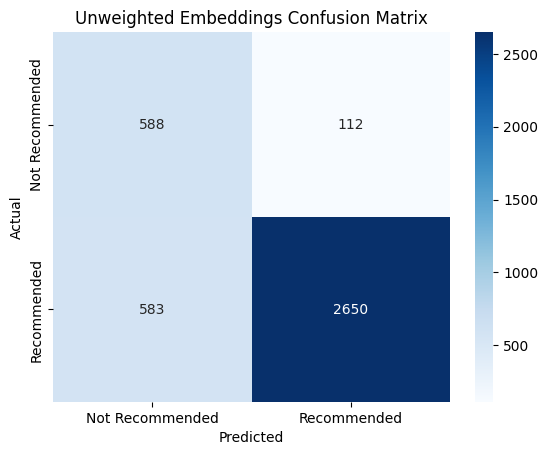

In [19]:
# Unweighted Embeddings with SMOTE and Heatmap
train_evaluate_and_plot_heatmap(unweighted_vectors, y, "Unweighted Embeddings")

TF-IDF Weighted Embeddings Accuracy: 0.7752351894228324
              precision    recall  f1-score   support

           0       0.42      0.74      0.54       700
           1       0.93      0.78      0.85      3233

    accuracy                           0.78      3933
   macro avg       0.68      0.76      0.70      3933
weighted avg       0.84      0.78      0.80      3933



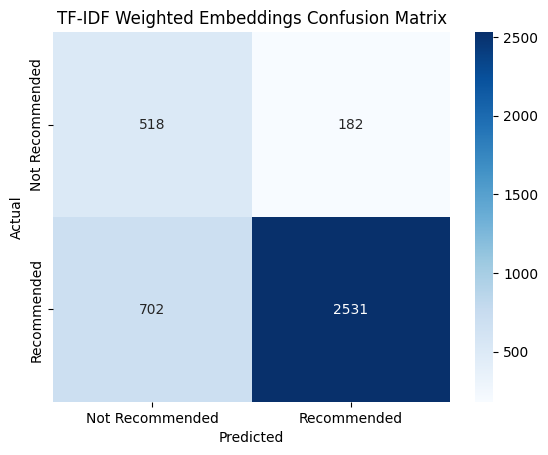

In [20]:
# TF-IDF Weighted Embeddings with SMOTE and Heatmap
train_evaluate_and_plot_heatmap(tfidf_weighted_vectors, y, "TF-IDF Weighted Embeddings")

Count Vectors Accuracy: 0.8220188151538266
              precision    recall  f1-score   support

           0       0.50      0.67      0.57       700
           1       0.92      0.86      0.89      3233

    accuracy                           0.82      3933
   macro avg       0.71      0.76      0.73      3933
weighted avg       0.85      0.82      0.83      3933



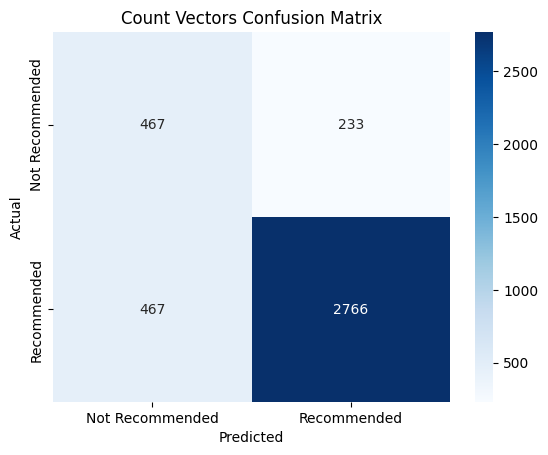

In [21]:
# Count Vectors with SMOTE and Heatmap
train_evaluate_and_plot_heatmap(count_vectors_matrix, y, "Count Vectors")

Unweighted Embeddings and Count Vectors achieve the highest accuracy, both exceeding 0.82, while TF-IDF Weighted Embeddings show a more moderate accuracy of 0.77. The heat maps across all three results display a similar pattern, reflecting overly optimistic predictions for the "Recommended" category, likely due to imbalance in the dataset. Overall, the accuracy in all three cases remains quite high when using only the review text.

Evaluate using 5-fold Cross-validation

In this section, I will evaluate the model using 5-fold cross-validation. SMOTE will be applied in order to oversamples the training data for the minority class within each fold.

In [33]:
# Cross-validation function
def cross_validate_model_with_smote(X, y, folds=5):
    # Create a pipeline with SMOTE and Logistic Regression
    pipeline = make_pipeline(SMOTE(random_state=42), LogisticRegression(max_iter=1000))
    
    # Use KFold cross-validation
    kfold = KFold(n_splits=folds, shuffle=True, random_state=42)
    
    # Define the accuracy scorer
    scorer = make_scorer(accuracy_score)
    
    # Perform cross-validation
    scores = cross_val_score(pipeline, X, y, cv=kfold, scoring=scorer)
    
    return scores

In [34]:
# 1. Unweighted Embeddings Cross-Validation
unweighted_scores = cross_validate_model_with_smote(unweighted_vectors, y)
print(f"Unweighted Embeddings Accuracy (5-fold): {np.mean(unweighted_scores):.4f}")
print("Fold Accuracies: ", unweighted_scores)

Unweighted Embeddings Accuracy (5-fold): 0.8170
Fold Accuracies:  [0.82252733 0.80676329 0.81612411 0.8181587  0.8214649 ]


The small variations between the accuracies indicate that the model is relatively stable across different subsets of data

In [35]:
# 2. TF-IDF Weighted Embeddings Cross-Validation
tfidf_scores = cross_validate_model_with_smote(tfidf_weighted_vectors, y)
print(f"TF-IDF Weighted Embeddings Accuracy (5-fold): {np.mean(tfidf_scores):.4f}")
print("Fold Accuracies: ", tfidf_scores)

TF-IDF Weighted Embeddings Accuracy (5-fold): 0.7765
Fold Accuracies:  [0.77370964 0.78032037 0.77619532 0.77466938 0.77746694]


The small variations between the accuracies indicate that the model is relatively stable across different subsets of data

In [36]:
# 3. Count Vectors Cross-Validation
count_scores = cross_validate_model_with_smote(count_vectors_matrix, y)
print(f"Count Vectors Accuracy (5-fold): {np.mean(count_scores):.4f}")
print("Fold Accuracies: ", count_scores)

Count Vectors Accuracy (5-fold): 0.8234
Fold Accuracies:  [0.82074752 0.81795067 0.82324517 0.82502543 0.82985758]


The small variations between the accuracies indicate that the model is relatively stable across different subsets of data

The 5-fold cross-validation demonstrates a roughly similiar result as when train model with train_test_split data. `Count vectors` outperform the other approaches with the highest average accuracy (82.34%) and the most consistent fold performances. `Unweighted embeddings` come in second with a slightly lower accuracy (81.70%), but still show stable and solid performance. `TF-IDF weighted embeddings` lag behind (77.65%) and, while consistent, do not seem to capture the text's essential patterns as effectively as the other two approaches.

---------------------------------------------------------------

### Q2: Does more information provide higher accuracy?

#### Only Title of the review

In [40]:
# Generate count vectors for review title
def generate_count_vectors_for_title(df, vocab_dict):
    count_vectorizer = CountVectorizer(vocabulary=vocab_dict)
    count_vectors = count_vectorizer.fit_transform(df['Title'])
    count_vectors_matrix = count_vectors.toarray()
    
    return count_vectors_matrix

In [41]:
# Compute unweighted embeddings for review title
def compute_unweighted_embeddings_for_title(df, embedding_index, embedding_dim):
    titles = df['Title'].tolist()
    unweighted_vectors = np.array([get_average_embedding(title, embedding_index, embedding_dim) for title in titles])
    return unweighted_vectors

# Compute TF-IDF weighted embeddings for review title
def compute_tfidf_weighted_embeddings_for_title(df, vocab_dict, embedding_index, embedding_dim):
    tfidf_vectorizer = TfidfVectorizer(vocabulary=vocab_dict)
    tfidf_matrix = tfidf_vectorizer.fit_transform(df['Title'])  # This is not needed explicitly
    idf_values = dict(zip(tfidf_vectorizer.get_feature_names_out(), tfidf_vectorizer.idf_))

    tfidf_weighted_vectors = np.array([
        get_tfidf_weighted_embedding(title, vocab_dict, idf_values, embedding_index, embedding_dim) 
        for title in df['Title']
    ])

    return tfidf_weighted_vectors

In [42]:
# Count Vectors for Title Cross-Validation
count_vectors_matrix_title = generate_count_vectors_for_title(data, vocab_dict)
count_scores_title = cross_validate_model_with_smote(count_vectors_matrix_title, y)
print(f"Count Vectors (Title) Accuracy (5-fold): {np.mean(count_scores_title):.4f}")
print("Fold Accuracies: ", count_scores_title)

Count Vectors (Title) Accuracy (5-fold): 0.7113
Fold Accuracies:  [0.70582253 0.71319603 0.72329603 0.7110885  0.70295015]


Fold accuracies show minimal variance, indicating that this model performs consistently across different subsets of the data. The range of fold accuracies (70.30% to 72.33%) suggests reliable generalization, but the overall performance is on the lower side.

In [43]:
# Unweighted Embeddings for Title Cross-Validation
unweighted_vectors_title = compute_unweighted_embeddings_for_title(data, embedding_index, embedding_dim)
unweighted_scores_title = cross_validate_model_with_smote(unweighted_vectors_title, y)
print(f"Unweighted Embeddings (Title) Accuracy (5-fold): {np.mean(unweighted_scores_title):.4f}")
print("Fold Accuracies: ", unweighted_scores_title)

Unweighted Embeddings (Title) Accuracy (5-fold): 0.7141
Fold Accuracies:  [0.71167048 0.7195525  0.73143438 0.71464903 0.69328586]


Fold accuracies are fairly consistent, except for one outlier at 69.33%. This suggests that the unweighted embeddings are generally stable but might not capture all of the nuances within the title data.

In [44]:
# TF-IDF Weighted Embeddings for Title Cross-Validation
tfidf_weighted_vectors_title = compute_tfidf_weighted_embeddings_for_title(data, vocab_dict, embedding_index, embedding_dim)
tfidf_scores_title = cross_validate_model_with_smote(tfidf_weighted_vectors_title, y)
print(f"TF-IDF Weighted Embeddings (Title) Accuracy (5-fold): {np.mean(tfidf_scores_title):.4f}")
print("Fold Accuracies: ", tfidf_scores_title)

TF-IDF Weighted Embeddings (Title) Accuracy (5-fold): 0.7425
Fold Accuracies:  [0.78743961 0.79481312 0.78662258 0.78204476 0.56180061]


However, the fold accuracies reveal a high variance, with scores ranging from 78.74% down to 56.18%. This suggests that while the TF-IDF approach can perform very well on some subsets of the data, it may be unstable and particularly sensitive to the composition of the titles in certain folds.

TF-IDF weighted embeddings show the best average performance (74.25%) for title-only data, but their instability across folds is a concern. The high variance in fold accuracies highlights that the model might be over-reliant on certain title-specific features.
Unweighted embeddings and count vectors perform similarly, both in the 71% range, with unweighted embeddings offering a slight edge. Their consistency across folds shows better generalization, though overall accuracy is lower than TF-IDF.
The results suggest that titles alone may not provide enough information for high-performing models, and while embedding-based methods can improve accuracy, they can also introduce instability depending on the specific data subsets.

#### Combination of Title and Review Text

In [48]:
# Concatenate title and review text for combined processing
def combine_title_and_review(df):
    return df['Title'].fillna('') + " " + df['Review Text'].fillna('')

In [49]:
# Generate count vectors for combined title and review
def generate_count_vectors_for_combined(df, vocab_dict):
    combined_text = combine_title_and_review(df)
    count_vectorizer = CountVectorizer(vocabulary=vocab_dict)
    count_vectors = count_vectorizer.fit_transform(combined_text)
    count_vectors_matrix = count_vectors.toarray()
    
    return count_vectors_matrix

# Compute unweighted embeddings for combined title and review
def compute_unweighted_embeddings_for_combined(df, embedding_index, embedding_dim):
    combined_text = combine_title_and_review(df)
    unweighted_vectors = np.array([get_average_embedding(review, embedding_index, embedding_dim) for review in combined_text])
    return unweighted_vectors

# Compute TF-IDF weighted embeddings for combined title and review
def compute_tfidf_weighted_embeddings_for_combined(df, vocab_dict, embedding_index, embedding_dim):
    combined_text = combine_title_and_review(df)
    tfidf_vectorizer = TfidfVectorizer(vocabulary=vocab_dict)
    tfidf_matrix = tfidf_vectorizer.fit_transform(combined_text)  # This is not needed explicitly
    idf_values = dict(zip(tfidf_vectorizer.get_feature_names_out(), tfidf_vectorizer.idf_))

    tfidf_weighted_vectors = np.array([
        get_tfidf_weighted_embedding(review, vocab_dict, idf_values, embedding_index, embedding_dim) 
        for review in combined_text
    ])

    return tfidf_weighted_vectors

In [50]:
# Count Vectors for Combined Cross-Validation
count_vectors_matrix_combined = generate_count_vectors_for_combined(data, vocab_dict)
count_scores_combined = cross_validate_model_with_smote(count_vectors_matrix_combined, y)
print(f"Count Vectors (Combined) Accuracy (5-fold): {np.mean(count_scores_combined):.4f}")
print("Fold Accuracies: ", count_scores_combined)

Count Vectors (Combined) Accuracy (5-fold): 0.8465
Fold Accuracies:  [0.84363082 0.84235952 0.84969481 0.84486267 0.8517294 ]


Fold accuracies show very little variance, with all values close to the mean, ranging from 84.24% to 85.17%. This consistency across different data folds suggests a high degree of model stability and generalization.

In [51]:
# Unweighted Embeddings for Combined Cross-Validation
unweighted_vectors_combined = compute_unweighted_embeddings_for_combined(data, embedding_index, embedding_dim)
unweighted_scores_combined = cross_validate_model_with_smote(unweighted_vectors_combined, y)
print(f"Unweighted Embeddings (Combined) Accuracy (5-fold): {np.mean(unweighted_scores_combined):.4f}")
print("Fold Accuracies: ", unweighted_scores_combined)

Unweighted Embeddings (Combined) Accuracy (5-fold): 0.8300
Fold Accuracies:  [0.83549453 0.82252733 0.83163784 0.83392675 0.82629705]


Fold accuracies show some minor fluctuation, with a range from 82.25% to 83.55%, indicating that the model is relatively consistent but may have slightly less stability compared to the count vectors.

In [52]:
# TF-IDF Weighted Embeddings for Combined Cross-Validation
tfidf_weighted_vectors_combined = compute_tfidf_weighted_embeddings_for_combined(data, vocab_dict, embedding_index, embedding_dim)
tfidf_scores_combined = cross_validate_model_with_smote(tfidf_weighted_vectors_combined, y)
print(f"TF-IDF Weighted Embeddings (Combined) Accuracy (5-fold): {np.mean(tfidf_scores_combined):.4f}")
print("Fold Accuracies: ", tfidf_scores_combined)

TF-IDF Weighted Embeddings (Combined) Accuracy (5-fold): 0.7915
Fold Accuracies:  [0.78769387 0.7943046  0.79577823 0.79069176 0.78916582]


Fold accuracies show minimal variance, with scores closely clustered around the mean. This stability indicates that the model generalizes well across different subsets, but the overall performance is weaker compared to count vectors and unweighted embeddings.

### Comparison

In this section I will plot the result data after experiment in 3 cases:
- Only title of the review 
- Only description/text of the review 
- Combination of the text and title of the review

In order to have a better visualization to compare

In [53]:
import matplotlib.pyplot as plt
import numpy as np

In [54]:
# Mean accuracies for each case
mean_unweighted = [np.mean(unweighted_scores), np.mean(unweighted_scores_title), np.mean(unweighted_scores_combined)]
mean_tfidf = [np.mean(tfidf_scores), np.mean(tfidf_scores_title), np.mean(tfidf_scores_combined)]
mean_count = [np.mean(count_scores), np.mean(count_scores_title), np.mean(count_scores_combined)]

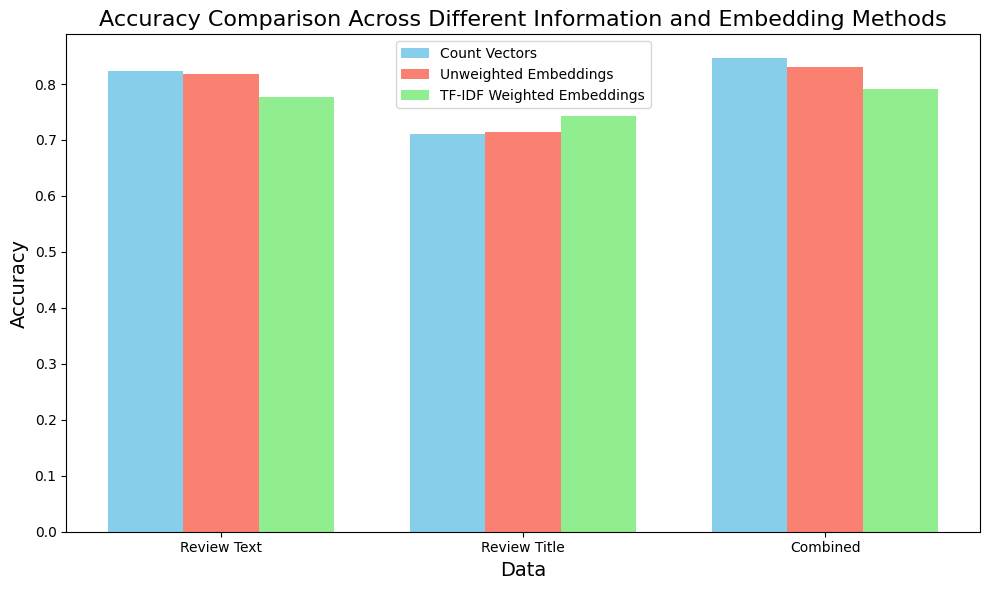

In [57]:
# Labels for the x-axis
labels = ['Review Text', 'Review Title', 'Combined']

# Plot the accuracy comparison
plt.figure(figsize=(10, 6))

# Bar width
bar_width = 0.25

# Set the positions of the bars on the x-axis
index = np.arange(len(labels))

# Plotting the bars
plt.bar(index, mean_count, bar_width, label='Count Vectors', color='skyblue')
plt.bar(index + bar_width, mean_unweighted, bar_width, label='Unweighted Embeddings', color='salmon')
plt.bar(index + 2 * bar_width, mean_tfidf, bar_width, label='TF-IDF Weighted Embeddings', color='lightgreen')

# Adding labels and title
plt.xlabel('Data', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Accuracy Comparison Across Different Information and Embedding Methods', fontsize=16)
plt.xticks(index + bar_width, labels)

# Display the legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

The chart clearly shows that combining the review text with the title significantly improves the model's accuracy. When using only the review title, the accuracy is lower compared to other cases. However, the combination of both text and title provides a noticeable improvement over using just the title, and a slight improvement compared to using only the review text.

Best Performances: The combination of title and text produces the highest accuracy across all models. Count vectors are the best overall method, followed by unweighted embeddings, while TF-IDF weighted embeddings lag behind. Using Only Title: Results in significantly lower accuracy, as titles alone provide too little information. Even the best-performing model (TF-IDF weighted embeddings) achieves only 74.25% accuracy, showing that titles alone are insufficient for reliable predictions. TF-IDF weighted embeddings improve compared to using the text alone (79.15% vs. 77.65%), but still fall short of the other methods. The improvement indicates that TF-IDF is more effective when additional data (like the title) is available, but it still struggles to outperform count vectors and unweighted embeddings. Combining both title and text consistently improves model performance across all methods, making it clear that both components offer complementary information.

## Summary
Give a short summary and anything you would like to talk about the assessment tasks here.

In the implementation of Task 2, I developed a bag-of-words model to generate a count vector from the `Review Text` descriptions. Additionally, I computed both unweighted and TF-IDF weighted embeddings. For the vector representations, I used GloVe as the embedding language model, as specified above.

In Task 3, I performed a 5-fold cross-validation on various feature representations of documents based on clothing reviews. The same language models used in Task 2 were applied here as well. Finally, I visualized the results to show how the model's performance varied across different scenarios.

## Couple of notes for all code blocks in this notebook
- please provide proper comment on your code
- Please re-start and run all cells to make sure codes are runable and include your output in the submission.   
<span style="color: red"> This markdown block can be removed once the task is completed. </span>